In [41]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import json
import glob
import re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import PrecisionRecallDisplay, mean_squared_error, precision_recall_fscore_support, precision_recall_curve
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud
from nltk import PorterStemmer

from surprise import Dataset, Reader, KNNBasic, SVD, NMF, KNNWithMeans, SVDpp
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy as sup_accuracy
from surprise import SVDpp
from surprise.model_selection import GridSearchCV



import warnings
# Ignore future deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')


In [42]:
#reviews = pd.read_csv(r"..\Data\.reviews_data.csv")
#reviews

In [43]:
# Rename the column at a specific index
#reviews.rename(columns={reviews.columns[0]: 'userId'}, inplace=True)


In [44]:
#reviews = reviews[['userId', 'placeid', 'rating', 'text', 'placeInfo' ]]
#reviews

In [45]:
# Split the dictionary-like item into separate columns
#item_info = reviews['placeInfo'].apply(lambda x: pd.Series(eval(x)))
#item_info.drop(columns='id', inplace=True)

# Concatenate the new columns with the original DataFrame
#reviews = pd.concat([reviews, item_info], axis=1)
#reviews.head()

In [46]:

# Split the dictionary-like item into separate columns
#address_info = reviews['addressObj'].apply(pd.Series)


# Concatenate the new columns with the original DataFrame
#reviews = pd.concat([reviews, address_info], axis=1)
#reviews.head()


In [47]:
# Calculate the percentage of NaN values in each column
#nan_percentage = reviews.isnull().sum() / len(reviews) * 100

# Define a threshold for excluding columns with a high percentage of NaN values
#nan_threshold = 50  # Adjust this value as needed

# Exclude columns with a high percentage of NaN values
#cleaned_dataset = reviews.dropna(thresh=len(reviews) - nan_threshold, axis=1)


In [48]:
# Remove rows with NaN variables
#reviews = reviews.dropna()
#reviews.drop(columns=['placeInfo', 'addressObj'], inplace=True)

# Set the desired sample size
#sample_size = 5000

# Perform random sampling
#random_sample = reviews.sample(n=sample_size, random_state=42)

In [49]:
#reviews

Columns to plot: Index(['userId', 'placeid', 'rating', 'latitude', 'longitude'], dtype='object')


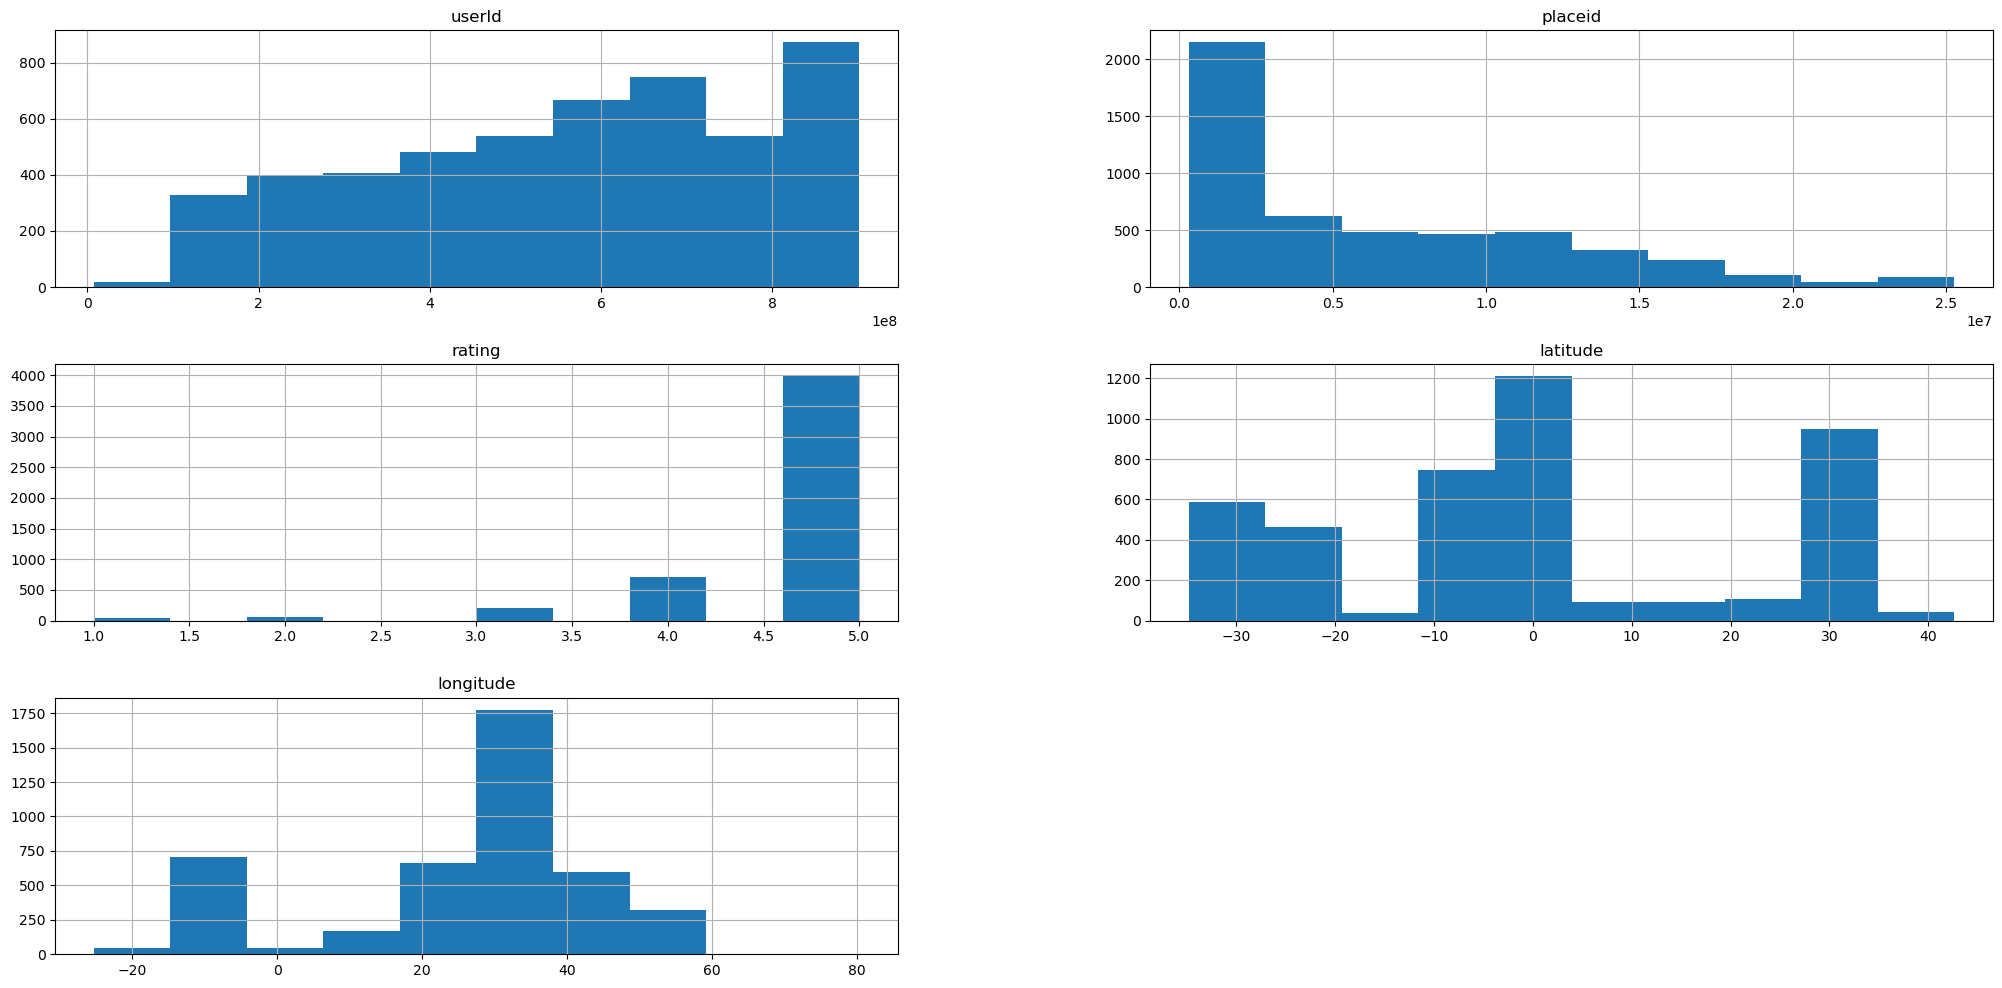

In [50]:
# Histogram plots for each data
# Select the numerical variables to plot
num_cols_to_plot = random_sample.select_dtypes(include=['int64', 'float64']).columns.drop([])
print("Columns to plot:",num_cols_to_plot )
# Create a histogram for each variable
random_sample[num_cols_to_plot].hist(figsize=(25, 12))
#plt.savefig('../Data/images/Columnstoplot')
plt.show()

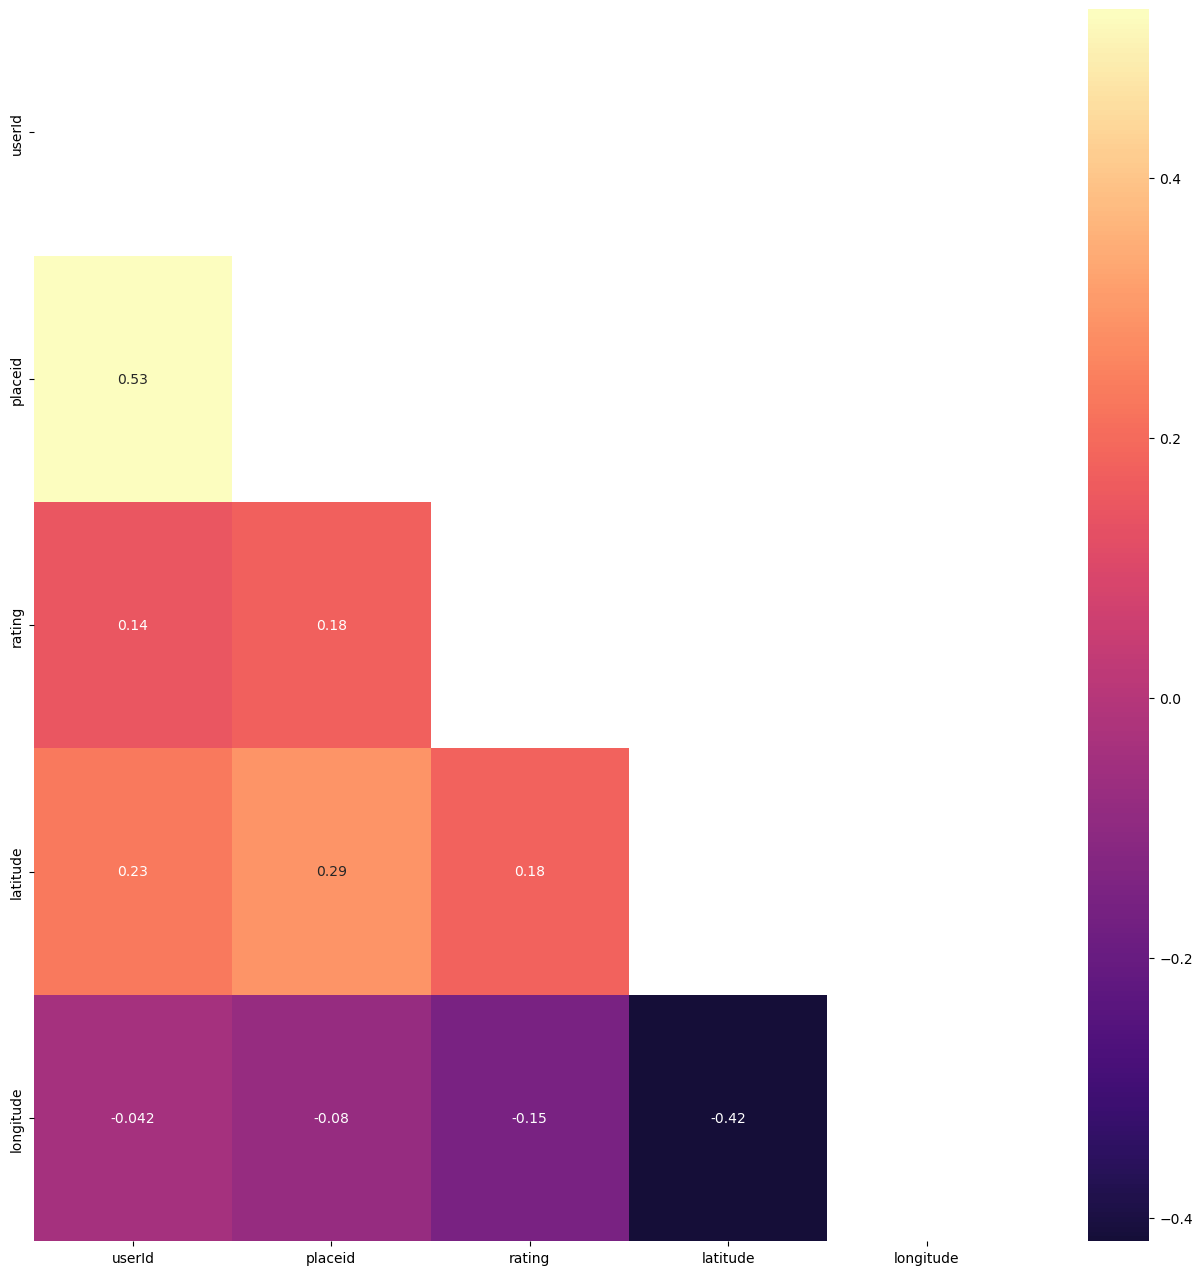

In [51]:
## Multicollinearity

# Create a correlation matrix
corr_matrix = random_sample.corr()
# Create a fig size
plt.figure(figsize=(16, 16))
# Create a mask to show only the lower triangle
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with the lower triangle mask applied
sns.heatmap(corr_matrix, mask=mask, cmap='magma', center=0, annot=True)
# Show the plot
plt.show();
# Save figure
#plt.savefig('../Data/images/multicollinearity.png')

In [52]:
model_data = pd.read_csv(r"..\Data\reviews_model_data.csv")
model_data

,userId,placeid,rating,lang,text
0,A87669AAD9DA05FFBD46F1334B329FFD,2189822,5,en,Gee is a passionate tour guide. The animals a...
1,9FFED7DDC68883BBB8F4024333970E9A,2189822,5,en,Lots to see. Easy to get to from the Safari Lo...
2,B5E56A483B579518DDD82A3DA0E94487,2189822,4,en,a kind of a zoo for injured and saved animals ...
3,882D0A6C7152105BB0D83C84F3CB160D,2189822,5,en,They do great rehabilitating injured animals. ...
4,203EBC7F3F51AAAA39A87D2E58842C76,2189822,5,en,"We took the guided tour from Isaac, who was gr..."
...,...,...,...,...,...
78567,DE7F7643421284F6E26B31283D2CCB85,2720312,5,en,Nothing I disliked.\nStopped her for an excell...
78568,D9205755480636B049F9DAFB8BE6FF12,2720312,5,en,"For travellers to the south west of Uganda, th..."
78569,FB3E9894020549D01D0468808AE93A5C,2720312,4,en,Located just a few miles outside Mbarara and h...
78570,8C31D999A4FC2AB2DC9824E3FFF82BE6,2720312,4,tr,Çok kaliteli ve temiz bir tesis . Yemekleri ço...


In [53]:
# Load the data into Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(model_data[['userId', 'placeid', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the model
model = SVD(random_state=42)
model.fit(trainset)

# Evaluate the model
predictions = model.test(testset)
accuracy = sup_accuracy.rmse(predictions)


RMSE: 0.7457


In [54]:
threshold = 3  # Define the threshold for positive predictions

true_positives = 0
false_positives = 0
false_negatives = 0

for prediction in predictions:
    if prediction.est >= threshold:
        if prediction.r_ui >= threshold:
            true_positives += 1
        else:
            false_positives += 1
    elif prediction.r_ui >= threshold:
        false_negatives += 1

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 0.96
Recall: 1.00


In [55]:
# Load the data into Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(model_data[['userId', 'placeid', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the model
model2 = NMF(random_state=42)
model2.fit(trainset)

# Evaluate the model
predictions2 = model2.test(testset)
accuracy2 = sup_accuracy.rmse(predictions2)
mae2 = sup_accuracy.mae(predictions2)

threshold = 3  # Define the threshold for positive predictions

true_positives = 0
false_positives = 0
false_negatives = 0

for prediction in predictions2:
    if prediction.est >= threshold:
        if prediction.r_ui >= threshold:
            true_positives += 1
        else:
            false_positives += 1
    elif prediction.r_ui >= threshold:
        false_negatives += 1

precision2 = true_positives / (true_positives + false_positives)
recall2 = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision2:.2f}")
print(f"Recall: {recall2:.2f}")

RMSE: 0.9041
MAE:  0.6994
Precision: 0.97
Recall: 0.96


In [56]:
# Load the data into Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(model_data[['userId', 'placeid', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define the item-based collaborative filtering model
model3 = SVDpp(random_state=42)

# Train the model
model3.fit(trainset)

# Make predictions on the test set
predictions3 = model3.test(testset)

# Evaluate the model using RMSE
rmse_score3 = sup_accuracy.rmse(predictions3)
mae3 = sup_accuracy.mae(predictions3)

# Extract the actual ratings and predicted ratings from the predictions
actual_ratings3 = [pred.r_ui for pred in predictions3]
predicted_ratings3 = [pred.est for pred in predictions3]

# Calculate the R-squared value
r_squared3 = r2_score(actual_ratings3, predicted_ratings3)
print("R-squared:", r_squared3) 

RMSE: 0.7488
MAE:  0.5121
R-squared: 0.22371232197981783


In [60]:
model_data.columns

Index(['userId', 'placeid', 'rating', 'lang', 'text'], dtype='object')

In [63]:
model_data['userId']

0        A87669AAD9DA05FFBD46F1334B329FFD
1        9FFED7DDC68883BBB8F4024333970E9A
2        B5E56A483B579518DDD82A3DA0E94487
3        882D0A6C7152105BB0D83C84F3CB160D
4        203EBC7F3F51AAAA39A87D2E58842C76
                       ...               
78567    DE7F7643421284F6E26B31283D2CCB85
78568    D9205755480636B049F9DAFB8BE6FF12
78569    FB3E9894020549D01D0468808AE93A5C
78570    8C31D999A4FC2AB2DC9824E3FFF82BE6
78571    B9405303068FFC6E8EEDCC92B9F817A0
Name: userId, Length: 78572, dtype: object

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaled_data = model_data[[ 'userId', 'placeid', 'rating']]
# Apply MinMaxScaler to 'rating' and 'Rank' columns
scaler = MinMaxScaler()
scaled_data[['rating', 'regional_rating']] = scaler.fit_transform(scaled_data[[ 'userId', 'placeid', 'rating']])

scaled_data[[ 'userId', 'placeid', 'rating']]

: 

In [57]:
from collections import defaultdict

def calculate_precision_recall(predictions, threshold):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for prediction in predictions:
        if prediction.est >= threshold:
            if prediction.r_ui >= threshold:
                true_positives += 1
            else:
                false_positives += 1
        elif prediction.r_ui >= threshold:
            false_negatives += 1
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    return precision, recall

def calculate_topn_hit_rate(predictions, topn):
    total_users = len({pred.uid for pred in predictions})
    topn_hits = 0

    user_ratings = defaultdict(list)
    for pred in predictions:
        user_ratings[pred.uid].append((pred.iid, pred.est))

    for uid, ratings in user_ratings.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topn_predictions = [iid for (iid, _) in ratings[:topn]]
        if uid in topn_predictions:
            topn_hits += 1

    return topn_hits / total_users

def evaluate_prediction_sets(prediction_sets, threshold, topn):
    for predictions, name in prediction_sets:
        precision, recall = calculate_precision_recall(predictions, threshold)
        hit_rate = calculate_topn_hit_rate(predictions, topn)
        
        print("Results for", name)
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"Top-{topn} Hit Rate: {hit_rate:.2f}")
        print()


In [58]:
# Usage example
prediction_sets = [
    (predictions, "Predictions 1"),
    (predictions2, "Predictions 2"),
    (predictions3, "Predictions 3"),
    #(predictions4, "Predictions 4"),
    #(predictions5, "Predictions 5"),
    #(predictions6, "Predictions 6"),
    #(predictions7, "Predictions 7"),
    #(predictions6, "Predictions 8"),
    #(predictions6, "Predictions 9"),
    #(predictions6, "Predictions 10"),
    #(predictions6, "Predictions 11"),
]

threshold = 3.5
topn = 5

evaluate_prediction_sets(prediction_sets, threshold, topn)

Results for Predictions 1
Precision: 0.89
Recall: 0.99
Top-5 Hit Rate: 0.00

Results for Predictions 2
Precision: 0.90
Recall: 0.92
Top-5 Hit Rate: 0.00

Results for Predictions 3
Precision: 0.89
Recall: 1.00
Top-5 Hit Rate: 0.00

